In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.4.0

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
ladec = pd.read_csv('/content/drive/MyDrive/ladec.csv')
subset = ladec[['c1', 'c2', 'stim', 'correctParse']]
correct = subset[subset["correctParse"] == 'yes']
c1, c2, cmp = ladec['c1'].to_list(), ladec['c2'].to_list(), ladec['stim'].to_list()

In [ ]:
kept_words = []
for w1, w2, wcmp in zip(c1, c2, cmp):
    if len(tokenizer.tokenize(w1)) == 1 \
        and len(tokenizer.tokenize(w2)) == 1 \
        and len(tokenizer.tokenize(wcmp)) == 1:
            kept_words.append((w1, w2, wcmp))

In [ ]:
glue_dict = {
    "training": {
        "sentence1": [w[0] for w in kept_words[:500]],
        "sentence2": [w[1] for w in kept_words[:500]],
        "compounds": [w[2] for w in kept_words[:500]],
        "label":      tf.convert_to_tensor([i for i in range(500)])
    },
    "validation": {
        "sentence1": [w[0] for w in kept_words[500:]],
        "sentence2": [w[1] for w in kept_words[500:]],
        "compounds": [w[2] for w in kept_words[500:]],
        "label":      tf.convert_to_tensor([i for i in range(500, len(kept_words))])
    }
}
glue_dict["training"]["compounds"]

['roundabout',
 'headache',
 'overall',
 'firearm',
 'firearms',
 'breakaway',
 'runaway',
 'paperback',
 'feedback',
 'fullback',
 'flashback',
 'quarterback',
 'horseback',
 'cornerback',
 'playback',
 'flashbacks',
 'baseball',
 'basketball',
 'handball',
 'football',
 'netball',
 'volleyball',
 'softball',
 'waistband',
 'database',
 'wheelbase',
 'databases',
 'heartbeat',
 'doorbell',
 'strawberry',
 'blackberry',
 'childbirth',
 'cupboard',
 'billboard',
 'keyboard',
 'dashboard',
 'cardboard',
 'starboard',
 'keyboards',
 'lifeboat',
 'steamboat',
 'somebody',
 'backbone',
 'collarbone',
 'cheekbones',
 'yearbook',
 'textbook',
 'handbook',
 'notebook',
 'textbooks',
 'newborn',
 'rainbow',
 'crossbow',
 'gearbox',
 'cowboy',
 'playboy',
 'cowboys',
 'heartbreak',
 'groundbreaking',
 'thoroughbred',
 'eyebrow',
 'eyebrows',
 'shipbuilding',
 'airbus',
 'blockbuster',
 'goodbye',
 'pancakes',
 'sugarcane',
 'landscape',
 'streetcar',
 'healthcare',
 'briefcase',
 'showcase',
 's

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

  return {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids
  }

In [ ]:
glue_train = bert_encode(glue_dict["training"], tokenizer)
glue_validation = bert_encode(glue_dict["validation"], tokenizer)

In [ ]:
import json
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=len(kept_words))

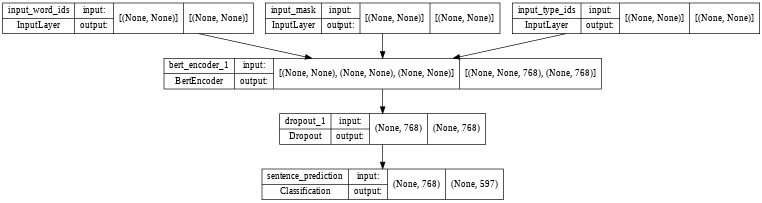

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_dict["training"]["label"])
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_dict["training"]["label"],
      validation_data=(glue_validation, glue_dict["validation"]["label"]),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
16/16 [==============================] - 62s 3s/step - loss: 6.4483 - accuracy: 0.0020 - val_loss: 6.4307 - val_accuracy: 0.0000e+00
Epoch 2/3
16/16 [==============================] - 44s 3s/step - loss: 6.4048 - accuracy: 0.0000e+00 - val_loss: 6.4545 - val_accuracy: 0.0000e+00
Epoch 3/3
16/16 [==============================] - 45s 3s/step - loss: 6.3764 - accuracy: 0.0020 - val_loss: 6.4612 - val_accuracy: 0.0000e+00


In [ ]:
my_examples = bert_encode({'sentence1':['road'], 'sentence2':['slide']}, tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples, training=False)
result = tf.argmax(result, axis=1).numpy()[0]
kept_words[result]

('rail', 'roads', 'railroads')

In [ ]:
#np.array(info.features['label'].names)[result]